# Conclusion: We get the best results for Linear Regression. Therefore, we plot the residual analysis plot for 'Linear Regression' only. The distribution of the plot indicates that model performs well over unseen data when compared to plot of train data. So,we can conclude that model is neither overfitting nor underfitting.

# Importing Necessary Libraries

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from pywaffle import Waffle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error,make_scorer
import joypy
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import ttest_ind,chi2_contingency
import warnings
warnings.filterwarnings('ignore')


# Load the data

In [25]:
df = pd.read_csv('covid_19_data.csv')

# Basic idea of data

In [26]:
print(df.head())
print(df.shape)
print(df.columns)

   SNo ObservationDate Province/State  Country/Region      Last Update  \
0    1      01/22/2020          Anhui  Mainland China  1/22/2020 17:00   
1    2      01/22/2020        Beijing  Mainland China  1/22/2020 17:00   
2    3      01/22/2020      Chongqing  Mainland China  1/22/2020 17:00   
3    4      01/22/2020         Fujian  Mainland China  1/22/2020 17:00   
4    5      01/22/2020          Gansu  Mainland China  1/22/2020 17:00   

   Confirmed  Deaths  Recovered  
0        1.0     0.0        0.0  
1       14.0     0.0        0.0  
2        6.0     0.0        0.0  
3        1.0     0.0        0.0  
4        0.0     0.0        0.0  
(10671, 8)
Index(['SNo', 'ObservationDate', 'Province/State', 'Country/Region',
       'Last Update', 'Confirmed', 'Deaths', 'Recovered'],
      dtype='object')


# Feature Exploration

In [27]:
# Handle missing values in 'Province/State': Replace NaN with 'Unknown'
df['Province/State'].fillna('Unknown', inplace=True)

# Convert 'ObservationDate' to datetime
df['ObservationDate'] = pd.to_datetime(df['ObservationDate'], format='%m/%d/%Y')

# Add a new feature: Active Cases = Confirmed - Deaths - Recovered
df['Active'] = df['Confirmed'] - df['Deaths'] - df['Recovered']

# Drop unnecessary columns: 'SNo' and 'Last Update'
df.drop(columns=['SNo', 'Last Update'], inplace=True)

# Inspect the cleaned data
print(df.head())


  ObservationDate Province/State  Country/Region  Confirmed  Deaths  \
0      2020-01-22          Anhui  Mainland China        1.0     0.0   
1      2020-01-22        Beijing  Mainland China       14.0     0.0   
2      2020-01-22      Chongqing  Mainland China        6.0     0.0   
3      2020-01-22         Fujian  Mainland China        1.0     0.0   
4      2020-01-22          Gansu  Mainland China        0.0     0.0   

   Recovered  Active  
0        0.0     1.0  
1        0.0    14.0  
2        0.0     6.0  
3        0.0     1.0  
4        0.0     0.0  


In [28]:
print(df.describe())
print(df.info())

                     ObservationDate      Confirmed        Deaths  \
count                          10671   10671.000000  10671.000000   
mean   2020-03-08 19:37:15.704244992     993.821666     40.667229   
min              2020-01-22 00:00:00       0.000000      0.000000   
25%              2020-02-28 00:00:00       3.000000      0.000000   
50%              2020-03-13 00:00:00      31.000000      0.000000   
75%              2020-03-23 00:00:00     229.000000      2.000000   
max              2020-03-31 00:00:00  105792.000000  12428.000000   
std                              NaN    6268.835379    398.618024   

          Recovered        Active  
count  10671.000000  10671.000000  
mean     289.508481    663.645956  
min        0.000000  -7024.000000  
25%        0.000000      2.000000  
50%        0.000000     16.000000  
75%       14.000000    120.000000  
max    63153.000000  77635.000000  
std     3010.809184   4138.959679  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067

In [29]:
numerical_features = ['Confirmed', 'Deaths', 'Recovered', 'Active']
categorical_features = ['Country/Region', 'Province/State']
target = 'Confirmed'  

# Statistical Analysis

In [ ]:
# Perform t-tests for each numerical feature against 'Confirmed'
results = {}

for feature in numerical_features:
    # Divide feature into two groups based on median
    high_group = df[df[feature] > df[feature].median()][target]
    low_group = df[df[feature] <= df[feature].median()][target]
    
    # Perform t-test
    stat, p_value = ttest_ind(high_group, low_group, equal_var=False)
    
    # Store results
    results[feature] = {'t-stat': stat, 'p-value': p_value}

# Print results
for feature, result in results.items():
    print(f"{feature} vs {target}:")
    print(f"T-Test: stat={result['t-stat']}, p-value={result['p-value']}\n")

# Chi-squared Test for Categorical Variables
contingency_table = pd.crosstab(df['Province/State'], df['Country/Region'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Squared Test: chi2={chi2}, p-value={p}")

Confirmed vs Confirmed:
T-Test: stat=16.470070072207683, p-value=1.748551219772205e-59

Deaths vs Confirmed:
T-Test: stat=15.953021208029528, p-value=1.1729827406469546e-55

Recovered vs Confirmed:
T-Test: stat=12.901271796930557, p-value=1.443134904118544e-37

Active vs Confirmed:
T-Test: stat=15.765782226721893, p-value=9.140657633014899e-55

Chi-Squared Test: chi2=105738.85637593376, p-value=0.0


# Vizualisation

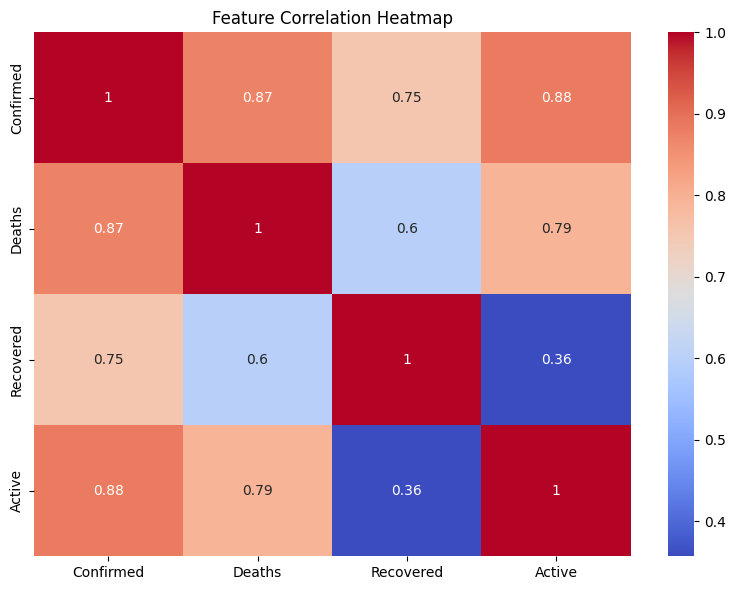

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[['Confirmed', 'Deaths', 'Recovered', 'Active']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


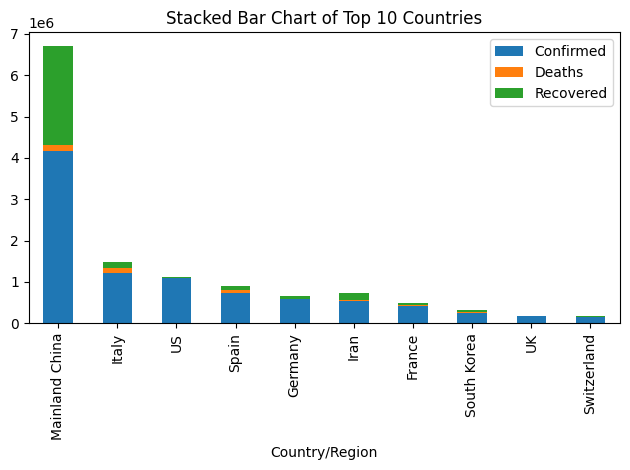

In [21]:
top_countries = df.groupby('Country/Region')[['Confirmed', 'Deaths', 'Recovered']].sum().sort_values(by='Confirmed', ascending=False).head(10)
top_countries.plot(kind='bar', stacked=True)
plt.title("Stacked Bar Chart of Top 10 Countries")
plt.tight_layout()
plt.show()


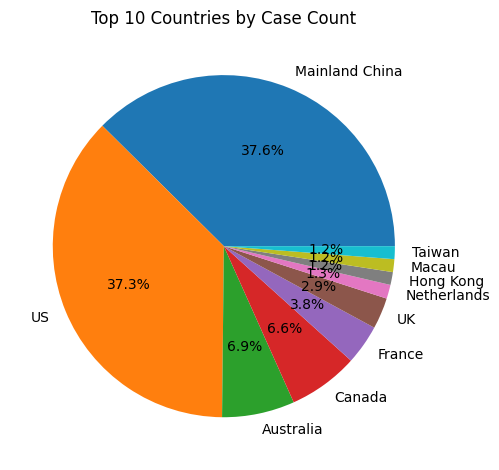

In [20]:
df['Country/Region'].value_counts().head(10).plot.pie(autopct='%1.1f%%')
plt.title("Top 10 Countries by Case Count")
plt.ylabel('')
plt.tight_layout()
plt.show()

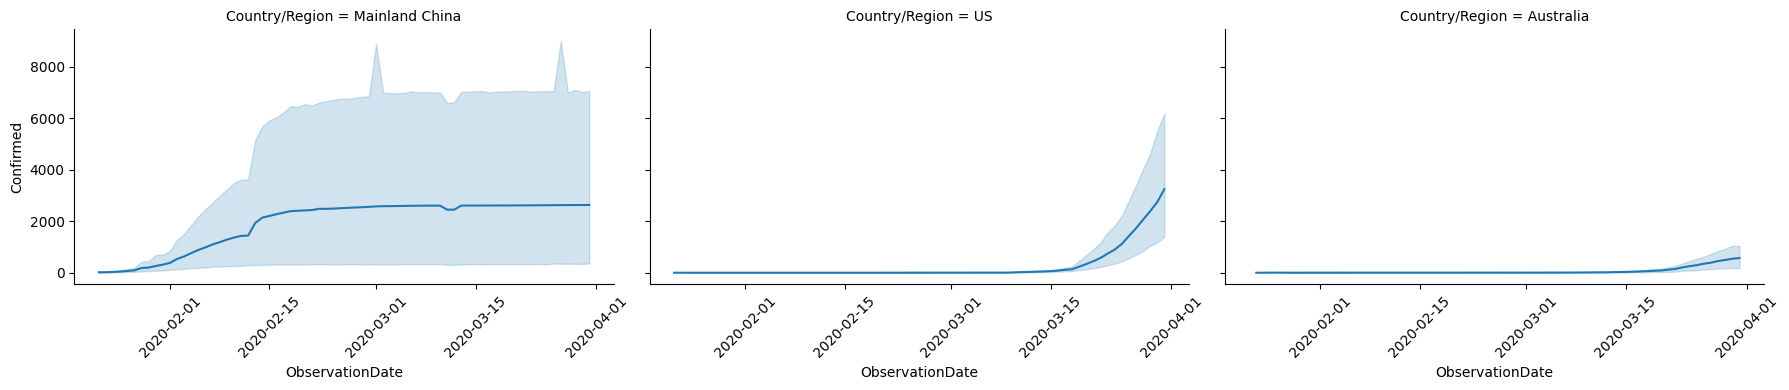

In [10]:
top_countries = df['Country/Region'].value_counts().head(3).index
subset = df[df['Country/Region'].isin(top_countries)]
g = sns.FacetGrid(subset, col="Country/Region", height=4,aspect=1.5)
g.map(sns.lineplot, "ObservationDate", "Confirmed")
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


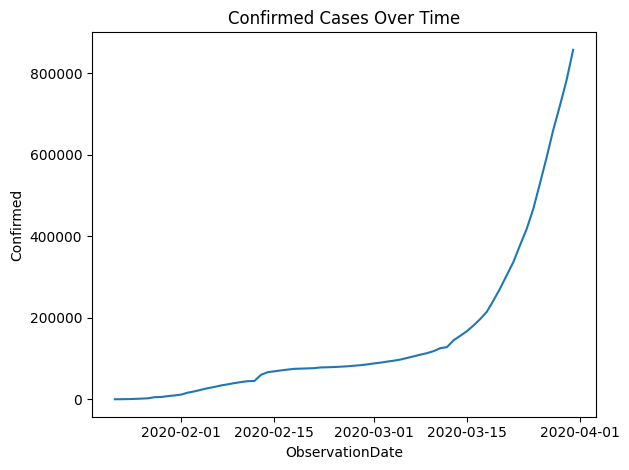

In [11]:
grouped_data = df.groupby('ObservationDate')['Confirmed'].sum().reset_index()
sns.lineplot(x='ObservationDate', y='Confirmed', data=grouped_data)
plt.title("Confirmed Cases Over Time")
plt.tight_layout()
plt.show()


# Preparing Data for Machine Learning

In [ ]:
numerical_features = ['Deaths', 'Recovered', 'Active']
categorical_features = ['Country/Region', 'Province/State']
target = 'Confirmed'  

# Splitting and defining x and y

In [ ]:
X = df[numerical_features + categorical_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)


# Model,Hyperparameters,Evaluation and Residual Analysis

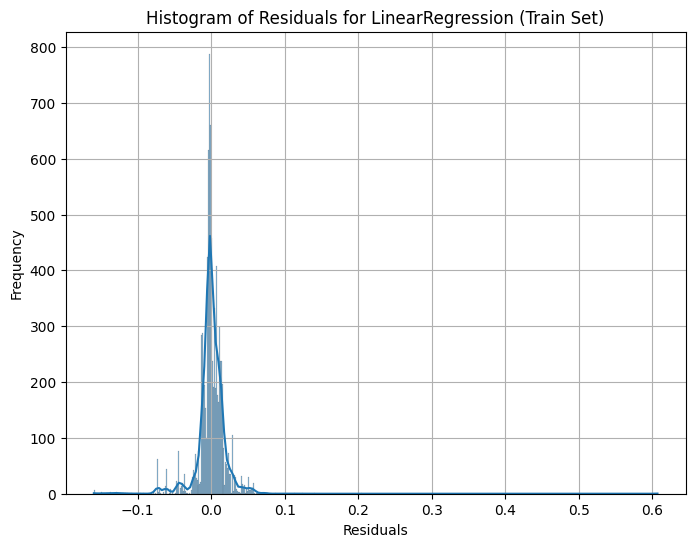

Model: LinearRegression
Cross-Validation Metrics: R2=1.0000, MSE=-0.0006, MAE=-0.0126, RMSE=-0.0249
Train Set Metrics: R2=1.0000, MSE=0.0005, MAE=0.0118, RMSE=0.0218
Test Set Metrics: R2=1.0000, MSE=0.0007, MAE=0.0121, RMSE=0.0266
--------------------------------------------------


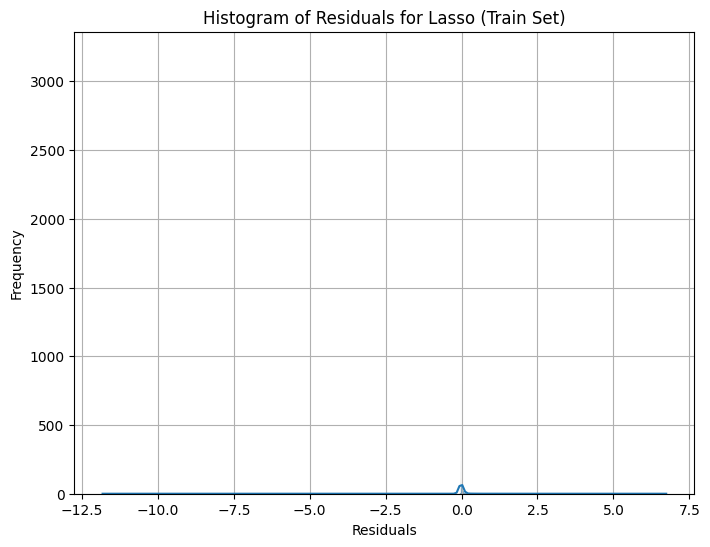

Model: Lasso
Cross-Validation Metrics: R2=1.0000, MSE=-0.1978, MAE=-0.0816, RMSE=-0.4262
Train Set Metrics: R2=1.0000, MSE=0.1635, MAE=0.0702, RMSE=0.4043
Test Set Metrics: R2=1.0000, MSE=0.1463, MAE=0.0659, RMSE=0.3825
--------------------------------------------------


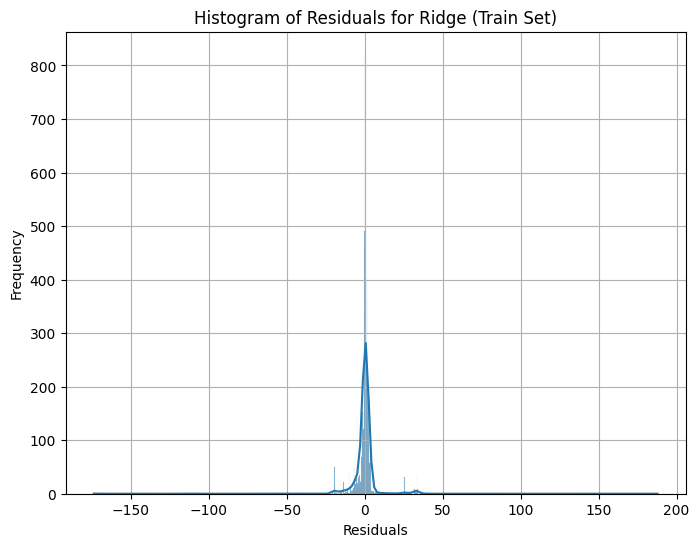

Model: Ridge
Cross-Validation Metrics: R2=1.0000, MSE=-83.5407, MAE=-2.9394, RMSE=-8.7180
Train Set Metrics: R2=1.0000, MSE=107.8457, MAE=3.4069, RMSE=10.3849
Test Set Metrics: R2=1.0000, MSE=172.7504, MAE=3.7618, RMSE=13.1435
--------------------------------------------------


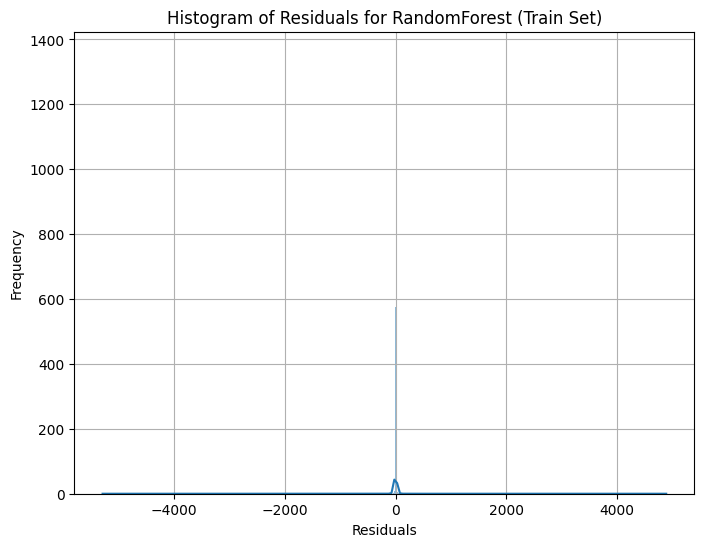

Model: RandomForest
Cross-Validation Metrics: R2=0.9962, MSE=-153922.6852, MAE=-34.8009, RMSE=-356.2339
Train Set Metrics: R2=0.9994, MSE=24167.9619, MAE=18.0816, RMSE=155.4605
Test Set Metrics: R2=0.9930, MSE=203018.6574, MAE=43.0565, RMSE=450.5759
--------------------------------------------------
Best-Performing Model: LinearRegression


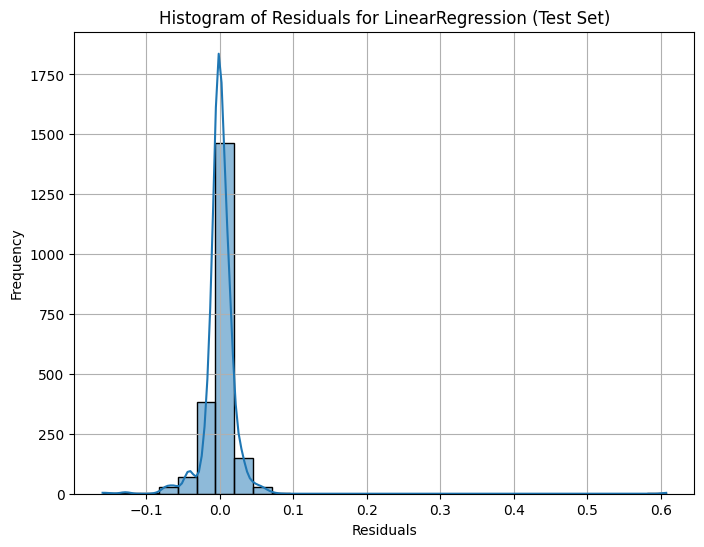

In [ ]:
# Models and Hyperparameters
models = {
    "LinearRegression": GridSearchCV(LinearRegression(), param_grid={}, cv=5),
    "Lasso": GridSearchCV(Lasso(), param_grid={"alpha": [0.01, 0.1, 1, 10]}, cv=5),
    "Ridge": Ridge(alpha=1.0),  # No tuning for Ridge
    "RandomForest": GridSearchCV(
        RandomForestRegressor(),
        param_grid={
            "n_estimators": [50, 100],
            "max_depth": [10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2, 4],
        },
        cv=5,
    ),
}

# Define cross-validation settings
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize results dictionary
cv_results = {}

# Scoring metrics for CV
scorers = {
    "r2": make_scorer(r2_score),
    "mse": make_scorer(mean_squared_error, greater_is_better=False),
    "mae": make_scorer(mean_absolute_error, greater_is_better=False),
    "rmse": make_scorer(
        lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False
    ),
}

for name, model in models.items():
    pipeline = Pipeline([("preprocessor", preprocessor), ("regressor", model)])

    # CV Metrics Storage
    metrics = {metric: [] for metric in scorers.keys()}

    for train_idx, val_idx in kf.split(X, y):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

        pipeline.fit(X_train_cv, y_train_cv)
        y_val_pred = pipeline.predict(X_val_cv)

        # Compute CV metrics
        metrics["r2"].append(r2_score(y_val_cv, y_val_pred))
        metrics["mse"].append(mean_squared_error(y_val_cv, y_val_pred))
        metrics["mae"].append(mean_absolute_error(y_val_cv, y_val_pred))
        metrics["rmse"].append(np.sqrt(mean_squared_error(y_val_cv, y_val_pred)))

    # Store mean CV metrics
    cv_results[name] = {metric: np.mean(values) for metric, values in metrics.items()}

    # Evaluate on train set
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    # Evaluate on test set
    y_test_pred = pipeline.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Residuals Calculation
    residuals_train = y_train - y_train_pred

    # Histogram of Residuals (Train Set)
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals_train, kde=True)
    plt.title(f"Histogram of Residuals for {name} (Train Set)")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Print model metrics
    print(f"Model: {name}")
    print(
        f"Cross-Validation Metrics: R2={cv_results[name]['r2']:.4f}, MSE={-cv_results[name]['mse']:.4f}, MAE={-cv_results[name]['mae']:.4f}, RMSE={-cv_results[name]['rmse']:.4f}"
    )
    print(
        f"Train Set Metrics: R2={train_r2:.4f}, MSE={train_mse:.4f}, MAE={train_mae:.4f}, RMSE={train_rmse:.4f}"
    )
    print(
        f"Test Set Metrics: R2={test_r2:.4f}, MSE={test_mse:.4f}, MAE={test_mae:.4f}, RMSE={test_rmse:.4f}"
    )
    print("-" * 50)

# Identify the best-performing model based on Cross-Validation RMSE
best_model_name = min(cv_results, key=lambda name: cv_results[name]["rmse"])
print(f"Best-Performing Model: {best_model_name}")

# Residual Histogram for Best-Performing Model
best_model = models[best_model_name]
best_pipeline = Pipeline([("preprocessor", preprocessor), ("regressor", best_model)])

# Fit the best model on the train data
best_pipeline.fit(X_train, y_train)

# Predictions and residuals for the test set
y_test_pred = best_pipeline.predict(X_test)
residuals_test = y_test - y_test_pred

# Plot the histogram of residuals (Test Set)
plt.figure(figsize=(8, 6))
sns.histplot(residuals_test, kde=True, bins=30)
plt.title(f"Histogram of Residuals for {best_model_name} (Test Set)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
